# Multi Label Classification

In [22]:
import scipy.io as sio
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
from gensim.models import Word2Vec, KeyedVectors
import multiprocessing
import sys
import datetime
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

8


In [23]:
# load a .mat file into a numpy array
def load_mat(filename):
    data = sio.loadmat(filename)
    # return data['data']
    return data

In [24]:
# Step 1: load the embeddings from word_2_vec format using keyedvectors
model = KeyedVectors.load_word2vec_format('../embeddings/ppi.txt', binary=False)
print(model)

INFO - 2023-11-27 04:15:10,404: loading projection weights from ../embeddings/ppi.txt
INFO - 2023-11-27 04:15:10,693: KeyedVectors lifecycle event {'msg': 'loaded (3890, 128) matrix of type float32 from ../embeddings/ppi.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-11-27T04:15:10.693111', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-88-generic-x86_64-with-glibc2.31', 'event': 'load_word2vec_format'}


KeyedVectors<vector_size=128, 3890 keys>


In [25]:
# Step 2: Also obtain the labels
data_np = load_mat('../datasets/ppi.mat')
labels_one_hot = data_np['group'].toarray()

print(labels_one_hot.shape)     # (10312, 39)

'''Now we know that the labels are one-hot encoded'''
label_sample = labels_one_hot[10]      # Thus, each node can have multiple labels (indicated by 2 ones in the array)
print(label_sample)

(3890, 50)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [26]:
# define the classification model: One vs rest classifier -> Obtained from ChatGPT
class TopKRanker(OneVsRestClassifier):
    def __init__(self, estimator=None):
        super(TopKRanker, self).__init__(estimator=estimator)

    def predict(self, X, top_k_list):
        assert X.shape[0] == len(top_k_list)
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = np.argsort(probs_)[-k:].tolist()  # Get indices of top k labels
            all_labels.append(labels)
        return all_labels


In [27]:
training_fraction = [0.1,0.2, 0.3, 0.4, 0.5,0.6, 0.7,0.8, 0.9]
dataset_size = labels_one_hot.shape[0]
embedding_dim = 128

micro_f1_scores = []
macro_f1_scores = []

# loop through the training fractions and see how micro and macro F1 scores change -> autocompleted by copilot
for fraction in training_fraction:
    # Step 3: Shuffle the dataset
    np.random.seed(0)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)

    # Step 4: Obtain the training and testing indices
    training_size = int(dataset_size * fraction)
    test_size = dataset_size - training_size
    training_indices = indices[:training_size]
    testing_indices = indices[training_size:]

    # Step 4.1: Initialize empty matrices for X_train and X_test
    X_train = np.zeros((training_size, embedding_dim))  # 'train_size' is the size of our training set
    X_test = np.zeros((test_size, embedding_dim))    # 'test_size' is the size of our test set

        # We need to populate 'train_indices' and 'test_indices' based on our train/test split

    # Populate X_train with embeddings for train set nodes
    for i, node_index in enumerate(training_indices):
        if str(node_index) in model:
            X_train[i] = model[str(node_index)]

    # Populate X_test with embeddings for test set nodes
    for i, node_index in enumerate(testing_indices):
        if str(node_index) in model:
            X_test[i] = model[str(node_index)]

    # Step 4.2: Obtain the training and testing labels
    y_train = labels_one_hot[training_indices]
    y_test = labels_one_hot[testing_indices]

    print("sample y_train:",y_train[0])
    # Step 5: Change the labels to a list of labels for OnevsRestClassifier
    train_labels = []
    test_labels = []
    for i in range(y_train.shape[0]):
        train_labels.append(np.where(y_train[i] == 1)[0].tolist())
    for i in range(y_test.shape[0]):
        test_labels.append(np.where(y_test[i] == 1)[0].tolist())

    # Step 6: Train the classifier
    classifier = TopKRanker(LogisticRegression())
    # classifier.fit(X_train, train_labels)
    classifier.fit(X_train, y_train)

    # Step 7: Obtain the predictions
    predictions = classifier.predict(X_test, top_k_list=[len(l) for l in test_labels])

    # Step 8: Calculate the micro and macro F1 scores
    mlb = MultiLabelBinarizer(classes=np.arange(50))
    binary_predictions = mlb.fit_transform(predictions)
    micro_f1 = f1_score(y_test, binary_predictions, average='micro')
    macro_f1 = f1_score(y_test, binary_predictions, average='macro')

    micro_f1_scores.append(micro_f1)
    macro_f1_scores.append(macro_f1)

    print("Training fraction: ", fraction)
    print("Micro F1 score: ", micro_f1)
    print("Macro F1 score: ", macro_f1)
    print("-------------------------------------------------")
    

sample y_train: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Training fraction:  0.1
Micro F1 score:  0.11355311355311355
Macro F1 score:  0.08313960222315453
-------------------------------------------------
sample y_train: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Training fraction:  0.2
Micro F1 score:  0.13386855862584018
Macro F1 score:  0.10374670607852288
-------------------------------------------------
sample y_train: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Training fraction:  0.3
Micro F1 score:  0.14246048697137975
Macro F1 score:  0.11395986359930799
-------------------------------------------------
sample y_train: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.

Text(0, 0.5, 'F1 score')

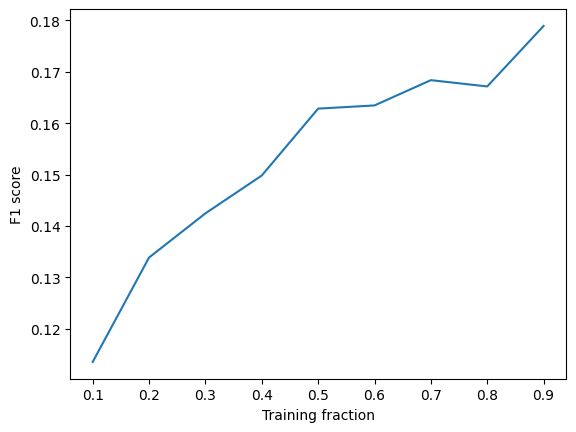

In [28]:
# plot the micro and macro f1 scores against training fraction
plt.plot(training_fraction, micro_f1_scores, label='micro f1')
plt.xlabel('Training fraction')
plt.ylabel('F1 score')

Text(0, 0.5, 'F1 score')

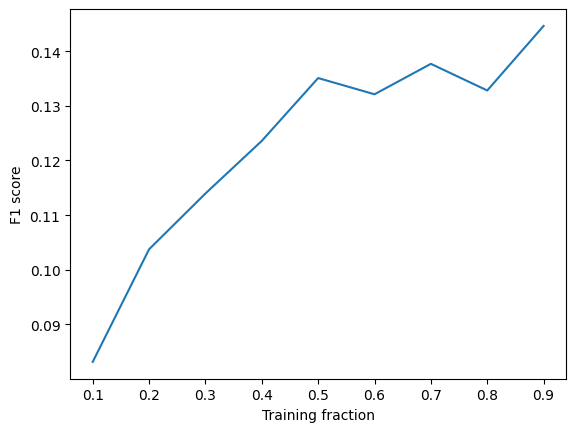

In [29]:
# plot the micro and macro f1 scores against training fraction
plt.plot(training_fraction, macro_f1_scores, label='macro f1')
plt.xlabel('Training fraction')
plt.ylabel('F1 score')